In [5]:

%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys
import os

import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.cluster.vq import kmeans2
from common.features import compute_sift_descriptors

if ".." not in sys.path:
    sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

# takes a position of a grid in the image and uses the cluster of sift desc to calculate the bag of features histgramm
def get_bag_of_words_histogram(sift_descriptors, page_frames, labels, x1, x2, y1, y2):
    # sift_descriptors: the sift descriptors of the full image
    # sift_descriptors_positions: the positions of the sift descriptors in the full image
    # sift_descriptors_labels_array: an array that contains a label for each sift descriptors
    # x1,x2,y1,y2: the positions of the frame

    # the function works as follows:
    # go over all descriptors inside the frame
    # for each one of them get its label
    # increment a counter for each label
    # return the histogram
    # the histogram is a map of this form {'label' : count} e.g {'f1' : 4} means that the label f1 is coming 4 times inside the frame
    assert (
        sift_descriptors.shape[0] == len(page_frames)
        and len(page_frames) == labels.shape[0]
    ), "wrong vars"

    label_to_count = {}
    for _, frame, label in zip(sift_descriptors, page_frames, labels):
        if frame[1] < x1 or frame[1] > x2 or frame[0] < y1 or frame[0] > y2:
            continue
        label_to_count[label] = label_to_count.get(label, 0) + 1
    return label_to_count


# compare for each window the difference in the two histograms
def compare_histograms(hist1, hist2, n_centroids):
    result = {}
    for i in range(n_centroids):
        label = i
        labelCountFromHist1 = hist1.get(label, 0)
        labelCountFromHist2 = hist2.get(label, 0)
        result[label] = abs(labelCountFromHist1 - labelCountFromHist2)
    return result



In [8]:

def getSortedWindowHistograms(
    imagePath: str,
    gtPath: str,
    hgtPath: str,
    x1: int,
    y1: int,
    x2: int,
    y2: int,
    n_centroids: int,
    window_step_size_x: int,
    window_step_size_y: int,
):
    """_summary_

    Args:
        imagePath (str): path to image file
        gtPath (str): path to ground truth file
        hgtPath (str): path to heuristic ground truth file
        x1 (int): the x1 coordinate of the request image
        y1 (int): the y1 coordinate of the request image
        x2 (int): the x2 coordinate of the request image
        y2 (int): the y2 coordinate of the request image
        n_centroids (int): the number of clusters to use when clustering the sift descriptors
        window_step_size_x (int): the number of pixels to slide the window in x direction
        window_step_size_y (int): the number of pixels to slide the window in y direction

    Returns:
        window_histograms_compared_to_request_image_histogram: a list of dicts that contains 3 objects.  1. 'window': the coordinates of a window in the format [x1,y1,x2,y2] 2. 'histogram': the bag of features histogram describing the difference between the window's histogram and the request image's histogram 3. 'absDifference': a number representing the absolute difference between the window's bag of features histogram and the request image's bag of features histogram
    """
    imageFile = Image.open(imagePath)
    im_arr = np.asarray(imageFile)
    im_height, im_width = im_arr.shape

    im_frames, im_sift_descriptors = compute_sift_descriptors(im_arr)

    # create a cluster of the full image
    _, cluster_labels = kmeans2(
        im_sift_descriptors, n_centroids, iter=20, minit="points"
    )

    # # bag of features histogram for the request image
    request_image_histogram = get_bag_of_words_histogram(
        im_sift_descriptors, im_frames, cluster_labels, x1, x2, y1, y2
    )

    # bag of features histograms for the windows
    window_width = x2 - x1
    window_height = y2 - y1
    window_x1 = 0
    window_y1 = 0
    window_x2 = window_x1 + window_width
    window_y2 = window_y1 + window_height

    window_histograms = (
        []
    )  # array of dicts {"window" : [x1,y1,x2,y2] , "histogram" : {...}}

    while True:
        print(
            f"compute histogram for window x1={window_x1} y1={window_y1} x2={window_x2} y2={window_y2}",
        )

        window_histogram = get_bag_of_words_histogram(
            im_sift_descriptors,
            im_frames,
            cluster_labels,
            window_x1,
            window_x2,
            window_y1,
            window_y2,
        )
        window_histograms.append(
            {
                "window": [window_x1, window_y1, window_x2, window_y2],
                "histogram": window_histogram,
            }
        )

        # shift the window to the right
        window_x1 += window_step_size_x
        window_x2 = window_x1 + window_width

        # go down if we processed the row
        if window_x2 > im_width:
            window_x1 = 0
            window_x2 = window_x1 + window_width
            window_y1 += window_step_size_y
            window_y2 = window_y1 + window_height

        # if we are done. break
        if window_y2 > im_height:
            break

    window_histograms_compared_to_request_image_histogram = []
    for wh in window_histograms:
        window = wh["window"]
        histogram = wh["histogram"]
        compared_histogram = compare_histograms(
            request_image_histogram, histogram, n_centroids
        )
        window_histograms_compared_to_request_image_histogram.append(
            {
                "window": window,
                "histogram": compared_histogram,
                "absDifference": sum(compared_histogram.values()),
            }
        )
    
    print("done computing histograms.")

    # sort window_histograms_compared_to_request_image_histogram based on similarity of the histograms
    # if the difference between 2 histograms is small. they are considered similar
    window_histograms_compared_to_request_image_histogram.sort(
        key=lambda item: item["absDifference"]
    )

    return window_histograms_compared_to_request_image_histogram


In [33]:
image = "2700270"
imagePath = f"./gw/pages/{image}.png"
gtPath = f"./gw/ground_truth/{image}.gtp"
hgtPath = f"./gw/heuristic_ground_truth/{image}.gtp"
n_centroids = 80
x1, y1, x2, y2 = 436 ,330 ,567 ,434 
window_step_size_x = 50
window_step_size_y = 50

sortedHistograms = getSortedWindowHistograms(imagePath, gtPath, hgtPath, x1, y1, x2, y2 ,n_centroids,window_step_size_x , window_step_size_y)


/home/amr/.local/lib/python3.8/site-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


compute histogram for window x1=0 y1=0 x2=131 y2=104
compute histogram for window x1=50 y1=0 x2=181 y2=104
compute histogram for window x1=100 y1=0 x2=231 y2=104
compute histogram for window x1=150 y1=0 x2=281 y2=104
compute histogram for window x1=200 y1=0 x2=331 y2=104
compute histogram for window x1=250 y1=0 x2=381 y2=104
compute histogram for window x1=300 y1=0 x2=431 y2=104
compute histogram for window x1=350 y1=0 x2=481 y2=104
compute histogram for window x1=400 y1=0 x2=531 y2=104
compute histogram for window x1=450 y1=0 x2=581 y2=104
compute histogram for window x1=500 y1=0 x2=631 y2=104
compute histogram for window x1=550 y1=0 x2=681 y2=104
compute histogram for window x1=600 y1=0 x2=731 y2=104
compute histogram for window x1=650 y1=0 x2=781 y2=104
compute histogram for window x1=700 y1=0 x2=831 y2=104
compute histogram for window x1=750 y1=0 x2=881 y2=104
compute histogram for window x1=800 y1=0 x2=931 y2=104
compute histogram for window x1=850 y1=0 x2=981 y2=104
compute histo

## Visualize the histograms

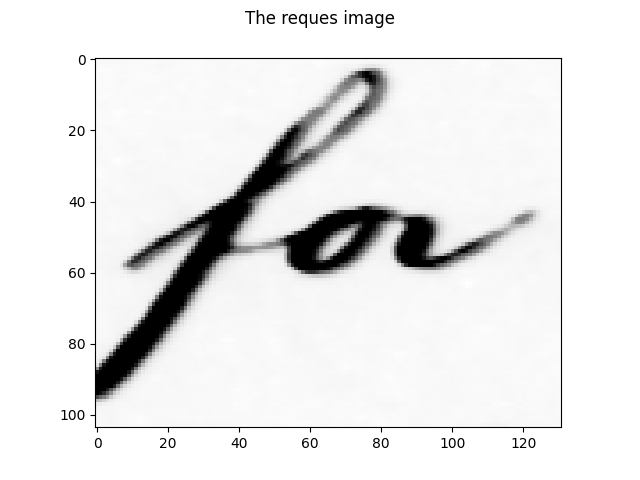

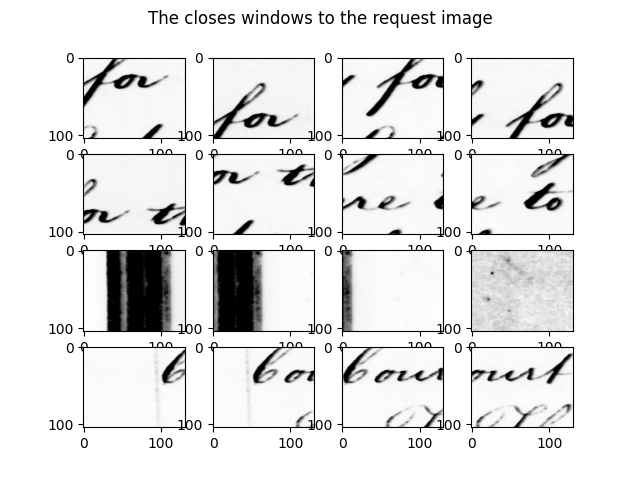

In [34]:
imageFile = Image.open(imagePath)
im_arr = np.asarray(imageFile)

# Show the request image
imageFig = plt.figure()
imageFig.suptitle("The reques image")
ax = imageFig.add_subplot(111)
ax.imshow(im_arr[y1:y2,x1:x2] , cmap=cm.get_cmap('Greys_r'))


# Show the most similar windows
show_for = 4
windowsFig, axs = plt.subplots(show_for, show_for)
windowsFig.suptitle("The closes windows to the request image")

# Iterate over the data and plot the images
for i , hist in enumerate(sortedHistograms[0:show_for * show_for]):
	wx1,wy1,wx2,wy2 = hist['window']
    # Calculate the row and column of the current subplot
	row = i // show_for
	col = i % show_for
	cropped_image = im_arr[wy1:wy2, wx1:wx2]
	axs[row,col].imshow(cropped_image , cmap=cm.get_cmap('Greys_r'))
